<a href="https://colab.research.google.com/github/Smasko7/Machine-Learning-Course/blob/main/Exercise_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Dollar Index timeseries data

In [ ]:
import yfinance as yf

ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)

In [ ]:
df = df.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1)
df

,Date,Open,High,Low,Close
0,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
1,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
2,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000
3,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001
4,2020-11-12 00:00:00-05:00,93.010002,93.139999,92.779999,92.959999
...,...,...,...,...,...
1252,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999
1253,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003
1254,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003
1255,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001


In [ ]:
import plotly.express as px

fig = px.line(df, x='Date', y=["Open", "High", "Low", "Close"])
fig.show()

## 2. Stationarity

From the plot above, we can observe that the time series of the four variables examined are non-stationary, as their mean seems to be changing across time, which indicates non zero trends. Also, the variance seems to be changing at different time periods (e.g. July - November 2022 appear to have higher variance than other time periods like July - November 2021). Also, we have to check covariance or run a statistical test like ADF to formally check the stationarity.

It should be mentioned that all 4 timeseries show similar behaviour, which is well-expected, as they represent different values of dollar in the same day, thus their large-scale pattern is similar (the 4 variables do not significantly differ for a specific day).

## 3. Problems of non-stationary time series

If we train a regressor on our non-stationary timeseries, the regressor will learn to predict values around the mean value. If the mean value of the dollar changes, the model will probably fail to predict around the new mean value, because the regressor assumes that the relationship between predictors and target values is stable.

Specifically, in our time series, the regressor will fit them according to the specific trend pattern (in large scale), but it cannot be sure about how the future trends will shift the time series in the future. Thus, it cannot generalize well to accurately forecast future dollar values. The timeseries may start to drift upwards or downwards (like in December 2022) and the regressor will not know how to follow those drifts.

## 4. June - July 2025 External Factor

During June 2025, the dollar significantly fell to a 3-year lowand in July 2025 it seems that it somewhat recovered. This fall in June 2025 was probably caused by the Trump's new tariff rates. Specifically, he increased the tariffs of imported goods, which contributed to uncertainty around U.S. trade policy and the economy and weakened the dollar.

## 5.
The close value of dollar for a future day cannot be deterministically described by a function f(o,h,l,c), because this would not include the external factors (covariates) that may affect the timeseries, as USA's strict interest rates policy did. This means that the modeling of the USD index has an inherit bias.

However, given that the USD index value is a stochastic process, if we are only interested in roughly estimating future values, we should collect as much training data as possible, include covariates and convert the time series from non-stationary to stationary as first steps.


## 6. - 7.
It would not make sense to split the data randomly into train and test set, because the temporal order of the data should be maintained. Each data point depends on previous points, so the test dataset must follow the train dataset. Thus, we will split the data chronologically.

In [ ]:
train_df = df[df['Date'] < '2024-01-01 00:00:00'].drop(columns = ['Date'])
test_df = df[(df['Date'] >= '2024-01-01 00:00:00') & (df['Date'] < '2025-01-01 00:00:00')].drop(columns = ['Date'])

train_df.shape, test_df.shape

((791, 4), (252, 4))

## 8. Create Dataframes

In [ ]:
import numpy as np

def create_timeframes(data_df, N):
    timeframes = []
    timeframe_targets = []
    data_array = data_df.to_numpy()


    for i in range(data_df.shape[0] - N):
        end = i + N
        timeframes.append(data_array[i: end])
        timeframe_targets.append(data_array[end, 3])

    return np.array(timeframes), np.array(timeframe_targets)




[[92.56999969 92.81999969 92.18000031 92.23000336]
 [92.23999786 92.95999908 92.12999725 92.73000336]
 [92.76000214 92.97000122 92.59999847 92.75      ]
 [92.69999695 93.20999908 92.61000061 93.04000092]
 [93.01000214 93.13999939 92.77999878 92.95999908]] (786, 5, 4) (786,)
[92.76000214 92.56999969 92.41999817 92.31999969 92.29000092]
[[92.23999786 92.95999908 92.12999725 92.73000336]
 [92.76000214 92.97000122 92.59999847 92.75      ]
 [92.69999695 93.20999908 92.61000061 93.04000092]
 [93.01000214 93.13999939 92.77999878 92.95999908]
 [92.94999695 93.01000214 92.70999908 92.76000214]]


## 9. Selection of timeframe size N

To forecast the USD index value of the next day, the timeframe size N must be small. In this way, we train the model to make short-term decisions for the future with enough training data (small N leads to bigger train dataset). Also, the distant past values may not significantly affect our short-term prediction, thus they are not necessary in training process.

To predict more distant future values, like the value in one month from now, we need a bigger timeframe (bigger N), in order to "catch" the large-scale properties of the timeseries. This means, we need to feed our model with more past values at each training step. However, N cannot be too big, because this will lead to small train set (if N = length(train_df) - 1 , then train set will have all the time series history but will be only one sample).

## 10. Train-Test Splits and Flattening

In [ ]:
N = 5
num_features = train_df.shape[1]

x_train, y_train = create_timeframes(train_df, N)
x_test, y_test = create_timeframes(test_df, N)

print(f"X_train and Y_train shapes before flattening: {x_train.shape} and {y_train.shape}")
print(f"X_test and Y_test shapes before flattening: {x_test.shape} and {y_test.shape}")

x_train_flat = x_train.reshape((x_train.shape[0], N*num_features))
x_test_flat = x_test.reshape((x_test.shape[0], N*num_features))

print(f"X_train and Y_train shapes after flattening: {x_train_flat.shape} and {y_train.shape}")
print(f"X_test and Y_test shapes after flattening: {x_test_flat.shape} and {y_test.shape}")

# print(x_train_flat[0])

X_train and Y_train shapes before flattening: (786, 5, 4) and (786,)
X_test and Y_test shapes before flattening: (247, 5, 4) and (247,)
X_train and Y_train shapes after flattening: (786, 20) and (786,)
X_test and Y_test shapes after flattening: (247, 20) and (247,)


## 11. Train different models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error

LinReg = LinearRegression()
LinReg.fit(x_train_flat, y_train)

RF = RandomForestRegressor()
RF.fit(x_train_flat, y_train)


BagReg = BaggingRegressor(estimator=LinearRegression())
BagReg.fit(x_train_flat, y_train)


estimators = [('lr', LinearRegression()), ('dtree', tree.DecisionTreeRegressor())]
StackReg = StackingRegressor(estimators=estimators)
StackReg.fit(x_train_flat, y_train)

linreg_train_mae = mean_absolute_error(y_train, LinReg.predict(x_train_flat))
linreg_test_mae = mean_absolute_error(y_test, LinReg.predict(x_test_flat))

rf_train_mae = mean_absolute_error(y_train, RF.predict(x_train_flat))
rf_test_mae = mean_absolute_error(y_test, RF.predict(x_test_flat))

BagReg_train_mae = mean_absolute_error(y_train, BagReg.predict(x_train_flat))
BagReg_test_mae = mean_absolute_error(y_test, BagReg.predict(x_test_flat))

StackReg_train_mae = mean_absolute_error(y_train, StackReg.predict(x_train_flat))
StackReg_test_mae = mean_absolute_error(y_test, StackReg.predict(x_test_flat))

print(f"Linear Regression train MAE: {linreg_train_mae}")
print(f"Linear Regression test MAE: {linreg_test_mae}")

print(f"Random Forest train MAE: {rf_train_mae}")
print(f"Random Forest test MAE: {rf_test_mae}")

print(f"Bagging Regressor train MAE: {BagReg_train_mae}")
print(f"Bagging Regressor test MAE: {BagReg_test_mae}")

print(f"Stacking Regressor train MAE: {StackReg_train_mae}")
print(f"Stacking Regressor test MAE: {StackReg_test_mae}")



Linear Regression train MAE: 0.34575245774919117
Linear Regression test MAE: 0.2845598676837101
Random Forest train MAE: 0.1502896697648607
Random Forest test MAE: 0.31149713925504513
Bagging Regressor train MAE: 0.3454163644583025
Bagging Regressor test MAE: 0.2857211859231077
Stacking Regressor train MAE: 0.35893874231269507
Stacking Regressor test MAE: 0.2891551722684146


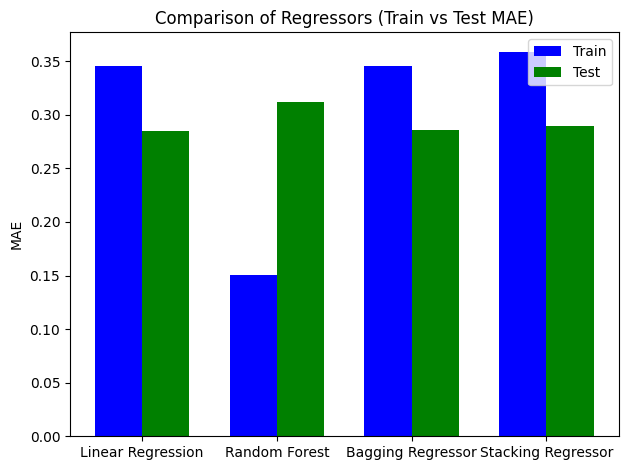

In [ ]:
import matplotlib.pyplot as plt

mae_train = [linreg_train_mae, rf_train_mae, BagReg_train_mae, StackReg_train_mae]
mae_test = [linreg_test_mae, rf_test_mae, BagReg_test_mae, StackReg_test_mae]
models = ["Linear Regression", "Random Forest", "Bagging Regressor", "Stacking Regressor"]

x = np.arange(len(models))

plt.bar(x - bar_width/2, mae_train, width=bar_width, label="Train", color="blue")
plt.bar(x + bar_width/2, mae_test, width=bar_width, label="Test", color="green")

plt.xticks(x, models)
plt.ylabel("MAE")
plt.title("Comparison of Regressors (Train vs Test MAE)")
plt.legend()
plt.tight_layout()
plt.show()

About the regression models that were used:

1. Linear Regression: Fits a straight line (or hyperplane) minimizing a loss function. It assumes linear relation between features and target (bias).

2. Random Forrest Regression: An ensemble of many decision trees trained on bootstrapped samples. The criterion of splitting nodes at each tree is the minimization of MSE. It averages predictions of each tree to get the final prediction (reduces variance).

3. Bagging Regressor: Trains many Linear Regression models on random subsets of data and averages their outputs to reduce overfitting.

4. Stacking Regressor: Combines predictions from multiple base models (here LR + Decision Tree Regressor) through a final estimator (here a RidgeCV - the function's default) to capture both linear and nonlinear patterns.

## 12.

In [ ]:
df = ticker.history(period="5y").reset_index(drop=False)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

df = df.drop(['Dividends', 'Stock Splits'], axis=1)



The addition of the monthly values as a feature to the dataset will most likely enhance the model performance, because the model will have the information about changes of the USD from month to month, so it will gain knowledge of more long-term relations between the samples. Besides, the model will learn interesting things about the timeseries' seasonality, which will boost the forecasting abilty.

In [ ]:
df_log_returns = df.copy()
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_log_returns[col] = np.log(1 + df_log_returns[col].pct_change())
df_log_returns

,Date,Open,High,Low,Close,Volume,Day,Month
0,2020-11-06 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,6,11
1,2020-11-09 00:00:00-05:00,-0.003571,0.001507,-0.000543,0.005407,NaN,9,11
2,2020-11-10 00:00:00-05:00,0.005622,0.000108,0.005089,0.000216,NaN,10,11
3,2020-11-11 00:00:00-05:00,-0.000647,0.002578,0.000108,0.003122,NaN,11,11
4,2020-11-12 00:00:00-05:00,0.003339,-0.000751,0.001834,-0.000860,NaN,12,11
...,...,...,...,...,...,...,...,...
1253,2025-10-31 00:00:00-04:00,0.003524,0.001203,0.005042,0.002709,NaN,31,10
1254,2025-11-03 00:00:00-05:00,0.002610,0.001501,0.002913,0.000701,NaN,3,11
1255,2025-11-04 00:00:00-05:00,0.002303,0.002697,0.000301,0.003498,NaN,4,11
1256,2025-11-05 00:00:00-05:00,0.001998,0.000997,0.003203,-0.000200,NaN,5,11


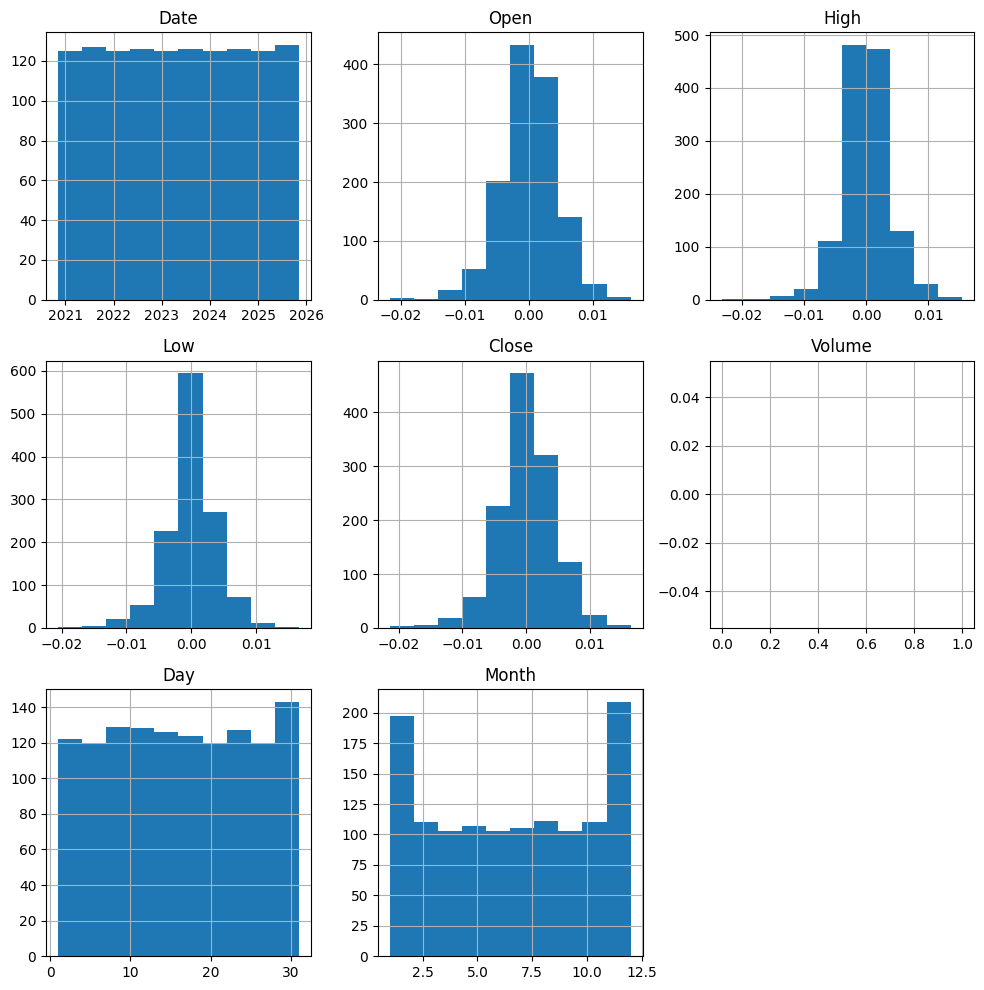

In [ ]:
df_log_returns.hist(figsize = (10,10))
plt.tight_layout()
plt.show()

The log returns will most likely enhance the models forecasting ability, because we can see now that the features' histograms show benefits like symmetry, normality and similar scaling (features Open, High, Low and Close). These factors make the features more easy to be handled by our models.

If a model makes a prediction about tomorrow's values: C_{t+1} = 0.01, this means that the value will increase. Specificallym if C_{t}=0.95, then the absolute predicted value will be:
C_abs_{t} = C_{t} * e^(C_{t+1}) = 0.95*e^(0.01) = 0.95955

## Retrain the models with the log returns

In [76]:
train_df_log_returns = df_log_returns[df_log_returns['Date'] < '2024-01-01 00:00:00'].drop(columns = ['Date'])
test_df_log_returns = df_log_returns[(df_log_returns['Date'] >= '2024-01-01 00:00:00') & (df_log_returns['Date'] < '2025-01-01 00:00:00')].drop(columns = ['Date'])

# train_df_log_returns.drop(columns = ['Volume'])
# test_df_log_returns.drop(columns = ['Volume'])

train_df_log_returns = train_df_log_returns.dropna(axis=1, how='all')
test_df_log_returns = test_df_log_returns.dropna(axis=1, how='all')

train_df_log_returns = train_df_log_returns.fillna(0)
test_df_log_returns = test_df_log_returns.fillna(0)


train_df_log_returns
test_df_log_returns


,Open,High,Low,Close,Day,Month
791,0.002172,0.008151,0.002668,0.008549,2,1
792,0.007172,0.004683,0.007276,0.002541,3,1
793,0.003030,-0.001949,0.000685,-0.000390,4,1
794,-0.000586,0.005544,-0.002352,-0.000098,5,1
795,0.000391,-0.004667,0.001667,-0.001955,8,1
...,...,...,...,...,...,...
1038,0.003148,0.000185,0.002226,0.002034,24,12
1039,0.000092,0.000000,0.001019,-0.001202,26,12
1040,-0.000832,-0.000924,-0.001482,-0.001203,27,12
1041,-0.000648,0.001662,-0.001206,0.001203,30,12


In [77]:
N = 5
num_features = train_df_log_returns.shape[1]

x_train_log_returns, y_train_log_returns = create_timeframes(train_df_log_returns, N)
x_test_log_returns, y_test_log_returns = create_timeframes(test_df_log_returns, N)

print(f"X_train and Y_train shapes before flattening: {x_train_log_returns.shape} and {y_train_log_returns.shape}")
print(f"X_test and Y_test shapes before flattening: {x_test_log_returns.shape} and {y_test_log_returns.shape}")

x_train_flat_log_returns = x_train_log_returns.reshape((x_train_log_returns.shape[0], N*num_features))
x_test_flat_log_returns = x_test_log_returns.reshape((x_test_log_returns.shape[0], N*num_features))

print(f"X_train and Y_train shapes after flattening: {x_train_flat_log_returns.shape} and {y_train_log_returns.shape}")
print(f"X_test and Y_test shapes after flattening: {x_test_flat_log_returns.shape} and {y_test_log_returns.shape}")

X_train and Y_train shapes before flattening: (786, 5, 6) and (786,)
X_test and Y_test shapes before flattening: (247, 5, 6) and (247,)
X_train and Y_train shapes after flattening: (786, 30) and (786,)
X_test and Y_test shapes after flattening: (247, 30) and (247,)


In [78]:
LinReg = LinearRegression()
LinReg.fit(x_train_flat_log_returns, y_train_log_returns)

RF = RandomForestRegressor()
RF.fit(x_train_flat_log_returns, y_train_log_returns)


BagReg = BaggingRegressor(estimator=LinearRegression())
BagReg.fit(x_train_flat_log_returns, y_train_log_returns)


estimators = [('lr', LinearRegression()), ('dtree', tree.DecisionTreeRegressor())]
StackReg = StackingRegressor(estimators=estimators)
StackReg.fit(x_train_flat_log_returns, y_train_log_returns)

linreg_train_mae = mean_absolute_error(y_train_log_returns, LinReg.predict(x_train_flat_log_returns))
linreg_test_mae = mean_absolute_error(y_test_log_returns, LinReg.predict(x_test_flat_log_returns))

rf_train_mae = mean_absolute_error(y_train_log_returns, RF.predict(x_train_flat_log_returns))
rf_test_mae = mean_absolute_error(y_test_log_returns, RF.predict(x_test_flat_log_returns))

BagReg_train_mae = mean_absolute_error(y_train_log_returns, BagReg.predict(x_train_flat_log_returns))
BagReg_test_mae = mean_absolute_error(y_test_log_returns, BagReg.predict(x_test_flat_log_returns))

StackReg_train_mae = mean_absolute_error(y_train_log_returns, StackReg.predict(x_train_flat_log_returns))
StackReg_test_mae = mean_absolute_error(y_test_log_returns, StackReg.predict(x_test_flat_log_returns))

print("LOG RETURNS: \n")

print(f"Linear Regression train MAE: {linreg_train_mae}")
print(f"Linear Regression test MAE: {linreg_test_mae}")

print(f"Random Forest train MAE: {rf_train_mae}")
print(f"Random Forest test MAE: {rf_test_mae}")

print(f"Bagging Regressor train MAE: {BagReg_train_mae}")
print(f"Bagging Regressor test MAE: {BagReg_test_mae}")

print(f"Stacking Regressor train MAE: {StackReg_train_mae}")
print(f"Stacking Regressor test MAE: {StackReg_test_mae}")

LOG RETURNS: 

Linear Regression train MAE: 0.003390776229796416
Linear Regression test MAE: 0.00286640595239191
Random Forest train MAE: 0.0013250445178042954
Random Forest test MAE: 0.0028123734627190536
Bagging Regressor train MAE: 0.0034361839076548647
Bagging Regressor test MAE: 0.002841079604841438
Stacking Regressor train MAE: 0.003488675660861144
Stacking Regressor test MAE: 0.0027194051304642057


## 13. Best Model

In [94]:
# Predictions_log_returns = StackReg.predict(x_test_flat_log_returns)

# predicted_absolute_values = [y_test[0]]
# Actual_absolute_values = [y_test[0]]


# for i in range(len(Predictions_log_returns)):
#     predicted_absolute_values.append(predicted_absolute_values[-1] * np.exp(Predictions_log_returns[i]))
#     Actual_absolute_values.append(Actual_absolute_values[-1] * np.exp(y_test_log_returns[i]))



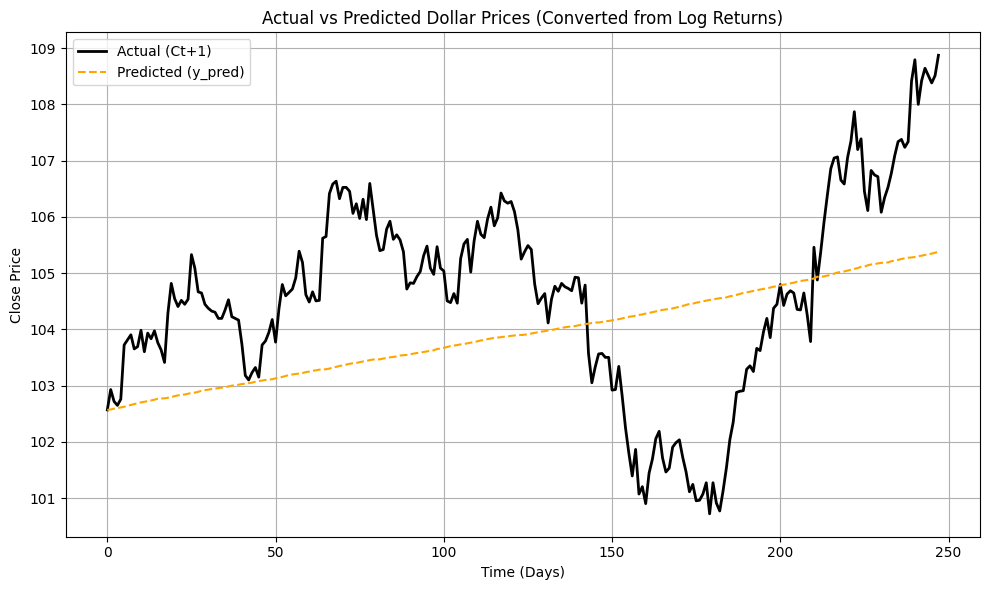

In [95]:
# plt.figure(figsize=(10, 6))
# plt.plot(Actual_absolute_values, label="Actual (Ct+1)", color="black", linewidth=2)
# plt.plot(predicted_absolute_values, label="Predicted (y_pred)", color="orange", linestyle="--")

# plt.title("Actual vs Predicted Dollar Prices (Converted from Log Returns)")
# plt.xlabel("Time (Days)")
# plt.ylabel("Close Price")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()